<a href="https://colab.research.google.com/github/haxzie/Facebook-PyTorch-Challenge/blob/master/PyTorch_flower_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x57eb2000 @  0x7f1df9fe42a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from collections import OrderedDict
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

In [3]:
!curl -O https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  297M  100  297M    0     0  14.5M      0  0:00:20  0:00:20 --:--:-- 16.0M


In [0]:
!unzip flower_data.zip

In [5]:
import os
print(os.getcwd())
data_dir = '/content/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

/content


In [6]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 7.5MB/s 
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


In [0]:
%matplotlib inline

In [0]:
# TODO: Define your transforms for the training and validation sets
data_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=data_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)

In [11]:
!curl -O https://raw.githubusercontent.com/haxzie/Facebook-PyTorch-Challenge/master/cat_to_name.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2218  100  2218    0     0   3898      0 --:--:-- --:--:-- --:--:--  3898


In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
def nn_setup(structure='vgg16',dropout=0.5, hidden_layer1 = 120,lr = 0.001):
    model = models.vgg16(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    classifier = nn.Sequential(OrderedDict([
        ('dropout',nn.Dropout(dropout)),
        ('inputs', nn.Linear(25088, hidden_layer1)),
        ('relu1', nn.ReLU()),
        ('hidden_layer1', nn.Linear(hidden_layer1, 90)),
        ('relu2',nn.ReLU()),
        ('hidden_layer2',nn.Linear(90,80)),
        ('relu3',nn.ReLU()),
        ('hidden_layer3',nn.Linear(80,102)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

    model.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr )
    model.cuda()
    return model , optimizer ,criterion

model, optimizer, criterion = nn_setup()

In [0]:
import sys

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')



# number of epochs to train the model
n_epochs = 3

valid_loss_min = np.Inf # track change in validation loss
print_every = 5
steps = 10

print('Training Starting....')

# move to cuda
model.cuda()

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    
    for batch_idx, (data, target) in enumerate(train_loader):
        sys.stdout.flush()
        print("Training Batch : ", batch_idx)
        model.cuda()
        model.train()
        data, target = data.cuda(), target.cuda()
        # move tensors to GPU if CUDA is available
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        if batch_idx % print_every == 0:
            model.eval()
            vlost = 0
            accuracy=0
        
            model.eval()
            for batch_idx, (data, target) in enumerate(valid_loader):
                data, target = data.cuda(), target.cuda()
                output = model(data)
                loss = criterion(output, target)

                valid_loss += loss.item()*data.size(0)
    
        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
        
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_checkpoin.pt')
        valid_loss_min = valid_loss

In [0]:
!wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/master/utils.py

In [0]:
import utils
gsync = utils.GDriveSync()
gsync.update_file_to_folder("model_checkpoin.pt")

In [25]:
def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    model.cuda()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

check_accuracy_on_test(valid_loader)

Accuracy of the network on the test images: 73 %


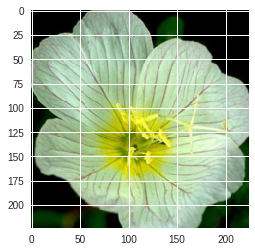

In [32]:

def process_image(image):
    img_pil = Image.open(image)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor
  
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


imshow(process_image(valid_dir+"/1/image_06739.jpg"))